# Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm follows the same procedure as the Deutsch-Josza algorithm but tackles a different problem.

1. [Problem Statement](#1.-Problem-Statement)
2. [Quantum Solution](#2.-Quantum-Solution)
3. [Qiskit Implementation](#3.-Qiskit-Implementation)
4. [Firsthand Experience with ibm_rensselaer](#4.-Firsthand-Experience-with-ibm_rensselaer)

## 1. Problem Statement

This problem involves finding a secret $n$-bit string, $s$, by querying an oracle that computes the dot product of $s$ and an input binary string $x$.

The dot product of $s$ and $x$ is the sum of the products of their elements:

$$s \cdot x = s_{n-1}x_{n-1} + \cdots + s_1x_1 + s_0x_0$$ 

The oracle function $f(x) = s \cdot x$ outputs $0$ or $1$. Our goal is to determine the unknown string $s$ by querying the oracle. 

### 1.1 Example

Consider the following simple example with the secret string $s = 1010$ and $3$ input strings $x$:

- For $x = 0010$, querying the oracle gives:

$$f(0010) = 1010 \cdot 0010 = (1 \times 0) + (0 \times 0) + (1 \times 1) + (0 \times 0) = 1$$

- For $x = 0101$, querying the oracle gives:

$$f(0101) = 1010 \cdot 0101 = (1 \times 0) + (0 \times 1) + (1 \times 0) + (0 \times 1) = 0$$

- For $x = s = 1010$, querying the oracle gives:

$$f(1010) = 1010 \cdot 1010 = (1 \times 1) + (0 \times 0) + (1 \times 1) + (0 \times 0) = 2\mod{2} = 0$$

Since we are working in binary, all operations are modulo $2$. The oracle outputs a $1$ if the dot product of the input string $x$ and the secret string $s$ (modulo $2$) is $1$, which occurs when the sum of the products is odd.

### 1.2 Classical Solution

Given the previous observation, we can determine the secret binary string $s$. Since we need to determine all $n$ bits of $s$, the classical solution requires $n$ queries. 

For example, if $n=4$:

$$f(0001) = s_3(0) + s_2(0) + s_1(0) + s_0(1) = s_0$$
$$f(0010) = s_3(0) + s_2(0) + s_1(1) + s_0(0) = s_1$$
$$f(0100) = s_3(0) + s_2(1) + s_1(0) + s_0(0) = s_2$$
$$f(1000) = s_3(1) + s_2(0) + s_1(0) + s_0(0) = s_3$$

## 2. Quantum Solution

Quantumly, we only need one query using the Bernstein-Vazirani Algorithm.

The algorithm follows the same procedure as the Deustch-Josza algorithm. First, we apply Hadamards to all $n$ qubits, query the oracle, and then apply Hadamards to all qubits again.

<center><img src="bernsteins_images/bernstein_circuit.png"></img></center>

### 2.1 IBM Quantum Composer

In this example with the composer, the secret string $s = 1101$.

IBM Quantum Composer: https://quantum.ibm.com/composer/

#### 2.1.1 Preprocessing

We prepare the ancilla qubit to be in the $\ket{-}$ state and apply Hadamards to all other qubits.

<center><img src="bernsteins_images/preprocessing.png"></img></center>

#### 2.1.2 Oracle

We construct the oracle using CNOTs such that the oracle produces the secret string $s$. For each $1$ in $s$, we apply a CNOT, using the qubit corresponding to the $1$ as the control and the ancilla qubit as the target.
<center><img src="bernsteins_images/oracle.png"></img></center>

#### 2.1.3 Postprocessing
Then we apply Hadamards and measurements to all qubits except for the ancilla qubit.
<center><img src="bernsteins_images/1101.png"></img></center>

## 3. Qiskit Implementation

For our implementation in Qiskit, we choose a larger secret bitstring, $s = 110101$.

### Imports

In [ ]:
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install numpy

In [1]:
import qiskit
print(qiskit.version.get_version_info())

1.2.4


### 3.1 Circuit Construction

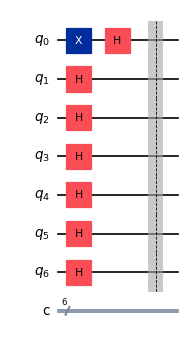

In [2]:
from qiskit import QuantumCircuit

# Preprocessing
# Select a secret bit string
s = '110101'

# Number of qubits to represent s
num_qubits = num_bits = len(s)

# Create a circuit with num_qubits + ancilla, and num_bits
qc = QuantumCircuit(num_qubits + 1, num_bits)

# Prepare ancilla qubit
qc.x(0)
qc.h(0)

# Apply Hadamards to all other qubits
qc.h(range(1, num_qubits + 1))

qc.barrier()

qc.draw(output="mpl", scale=0.6)

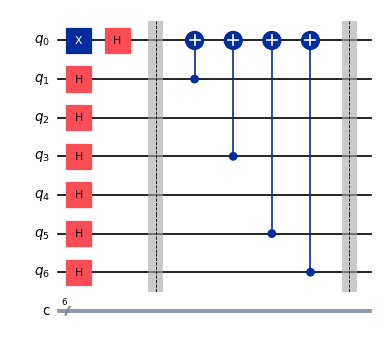

In [3]:
# Oracle
# Reverse s to fit Qiskit's qubit ordering (bottom up 110101 -> top down 101011)
reverse_s = s[::-1] 

# Apply CNOT to all qubits with 1 as control and target as ancilla (Qubit 0)
for q in range(num_qubits):
    if reverse_s[q] == "1":
        qc.cx(q + 1, 0)

qc.barrier()

qc.draw(output="mpl", scale=0.6)

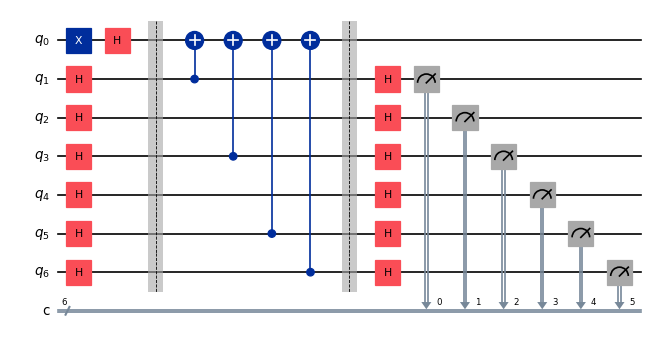

In [4]:
# Post processing and measurement
# Apply Hadamards to all other qubits
qc.h(range(1, num_qubits + 1))

# Measure all other qubits
for q in range(num_qubits):
    qc.measure(q + 1, q)

qc.draw(output="mpl", scale=0.6)

### 3.2 Running on a Simulator

First, we initialize a StatevectorSampler primitive that classically simulates the execution of quantum circuits. Then, we run the primitive with 4096 shots and retrieve its results.

The counts are: {'110101': 4096}
Our result matches the secret string s, 110101


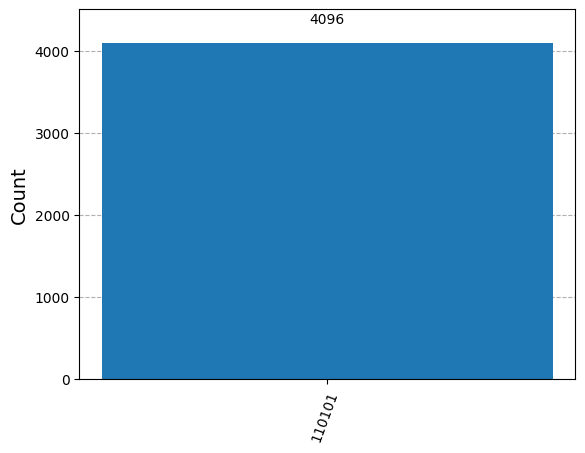

In [5]:
# Running on Simulator
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram

sampler = StatevectorSampler()

sim_qc = qc

# Run using sampler
result = sampler.run([sim_qc], shots=4096).result()

# Get counts for the classical register "c"
counts = result[0].data.c.get_counts()
print(f"The counts are: {counts}")

# Verify we get the correct answer
assert(s == list(counts.keys())[0])

print("Our result matches the secret string s, " + s)

plot_histogram(counts)

## 4. Firsthand Experience with ibm_rensselaer

As usual, we initialize the ``QiskitRuntimeService`` to interact with IBM Quantum resources.

If you have not already, use the following snippet to log in and save your IBM Quantum account credentials for future use. Replace the ``token`` with your own API token available when you log in at https://quantum.ibm.com/.

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="token",
#     set_as_default=True,
#     # Use 'overwrite=True' if you're updating your token.
#     overwrite=True,
# )

In [7]:
service = QiskitRuntimeService()

# Should be "ibm_rensselaer". If not and you have access to the computer, comment this out and set the backend manually.
# backend = service.least_busy(operational=True, simulator=False)
# print(backend.name)

backend = service.backend("ibm_rensselaer")
print(backend.name)

ibm_rensselaer


We use a preset pass manager with minimal options to transpile our current Bernstein circuit into the basis gates of the backend we are using, ``ibm_rensselaer``.

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(target=backend.target, optimization_level=1)

isa_circuit = pm.run(qc)
# isa_circuit.draw(output='mpl',scale=0.5)

Then, we initialize a Sampler with the backend to execute the circuit on ``ibm_rensselaer``. This should take a couple of seconds.

After the job is done executing, we retrieve the job results. Due to inherent noise in real hardware, we filter the measurements to emphasize the most probable outcome.

Secret s: 110101
The counts are: {'010100': 340, '010101': 318, '110101': 871, '000101': 111, '100100': 228, '111101': 59, '110001': 122, '110100': 579, '100101': 333, '010001': 57, '110110': 66, '110111': 99, '000000': 46, '100001': 72, '000100': 157, '110000': 91, '010110': 41, '100111': 55, '010000': 44}


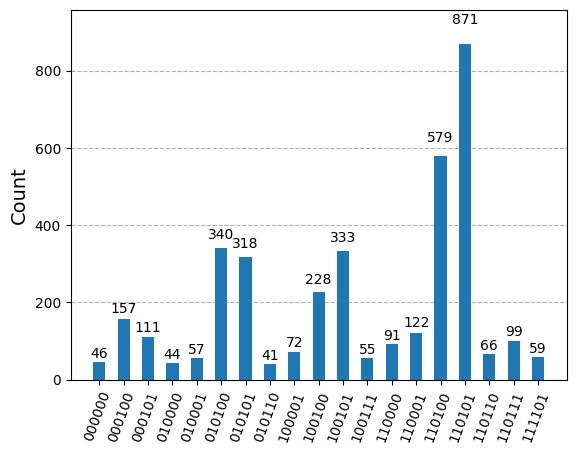

In [9]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=4096)
job_result = job.result()
counts = job_result[0].data.c.get_counts()

# Set filtering threshold to be 1% of the default number of shots (4096)
threshold = int(0.01 * 4096)
filteredCounts = {k: v for k,v in counts.items() if v >= threshold}

print("Secret s:", s)

print(f"The counts are: {filteredCounts}")

plot_histogram(filteredCounts)